In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
# Since you are using Jupyter locally, ensure the CSV is in the same folder
CSV_PATH = 'geant-flat-tms.csv'
BATCH_SIZE = 64

print("Loading and Processing Data with Time Feature...")

Loading and Processing Data with Time Feature...


In [3]:
# 1. Load Data (Keep header=None)
df = pd.read_csv(CSV_PATH, header=None)

In [10]:
print("Processing Traffic Data...")
# Convert columns 1-529 to floats, handling any errors
traffic_raw = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').values.astype(np.float32)
traffic_raw = np.nan_to_num(traffic_raw)

# Log-Scale Traffic (Handle the massive 300,000+ values)
traffic_log = np.log1p(traffic_raw)

# Normalize Traffic to [-1, 1] for the Neural Network
t_max = np.max(traffic_log)
t_min = np.min(traffic_log)

# Avoid division by zero if data is flat
if t_max - t_min > 0:
    traffic_norm = (traffic_log - t_min) / (t_max - t_min)
    traffic_norm = (traffic_norm * 2) - 1
else:
    traffic_norm = traffic_log

Processing Traffic Data...


In [11]:
# --- 3. Process Time Column (Column 0) ---
print("Processing Time Column...")

# Function: "2005-01-01-00-30" -> Float 0.30
# Function: "2005-01-01-00-30" -> Float 0.5 (representing 00:30)
def parse_time_to_float(time_str):
    # Split by '-': ['2005', '01', '01', '00', '30']
    parts = str(time_str).split('-')
    
    # Extract Hour and Minute
    hh = float(parts[-2])
    mm = float(parts[-1])
    
    # --- THE FIX ---
    # Convert to "Hours from start of day"
    # Example: 01:45 becomes 1.75
    time_numeric = hh + (mm / 60.0)
    
    return time_numeric

# Apply function
time_floats = df.iloc[:, 0].apply(parse_time_to_float).values.astype(np.float32)

# Normalize Time to [-1, 1]
# Max time is now exactly 24.0.
time_norm = (time_floats / 24.0) * 2 - 1
time_norm = time_norm.reshape(-1, 1)

print(f"Sample Check:")
print(f"Original: {df.iloc[20,0]}") # 2005-01-01-00-30
print(f"Float:    {time_floats[20]}") # Should be 0.5 (not 0.30)

Processing Time Column...
Sample Check:
Original: 2005-01-01-05-30
Float:    5.5


In [12]:
# --- 4. Merge Time + Traffic ---
# Stack them side-by-side. 
# Result: [Time (1 column) | Traffic (529 columns)]
data_combined = np.hstack((time_norm, traffic_norm))

print(f"Traffic Shape: {traffic_norm.shape}")
print(f"Time Shape:    {time_norm.shape}")
print(f"Merged Shape:  {data_combined.shape} (Input for WGAN)")

# --- 5. Create PyTorch Loader ---
tensor_x = torch.from_numpy(data_combined)
dataset = TensorDataset(tensor_x)
# drop_last=True prevents crashes if the last batch is too small
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# --- 6. Verification ---
print("\n--- Verification: Row 0 ---")
print(f"Original Time String: {df.iloc[0,0]}")
print(f"Converted Float:      {time_floats[0]}")
print(f"Normalized Time Input: {time_norm[0][0]:.4f} (Should be between -1 and 1)")

# Save these stats! We need them later to convert output back to real numbers.
print(f"\nNOTE: Save these values for the Generator later:")
print(f"Log Min: {t_min}")
print(f"Log Max: {t_max}")

Traffic Shape: (10772, 529)
Time Shape:    (10772, 1)
Merged Shape:  (10772, 530) (Input for WGAN)

--- Verification: Row 0 ---
Original Time String: 2005-01-01-00-30
Converted Float:      0.5
Normalized Time Input: -0.9583 (Should be between -1 and 1)

NOTE: Save these values for the Generator later:
Log Min: 0.0
Log Max: 22.94443130493164


In [13]:
import torch
import torch.nn as nn

# --- Configuration ---
# The input is a random noise vector of size 100
Z_DIM = 100
# The output must match your dataset columns (529 links)
DATA_DIM = 530
HIDDEN_DIM = 128

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Layer 1: Takes random noise -> Expands to Hidden Size
            nn.Linear(Z_DIM, HIDDEN_DIM),
            nn.LayerNorm(HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            
            # Layer 2: Expands again
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM * 2),
            nn.LayerNorm(HIDDEN_DIM * 2),
            nn.LeakyReLU(0.2),
            
            # Layer 3: Expands again
            nn.Linear(HIDDEN_DIM * 2, HIDDEN_DIM * 4),
            nn.LayerNorm(HIDDEN_DIM * 4),
            nn.LeakyReLU(0.2),
            
            # Output Layer: Compresses down to exact data size (529)
            nn.Linear(HIDDEN_DIM * 4, DATA_DIM),
            nn.Tanh() # CRITICAL: Forces output to be between -1 and 1
        )

    def forward(self, x):
        return self.net(x)

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            # Layer 1: Takes real/fake data (529) -> Compresses
            nn.Linear(DATA_DIM, HIDDEN_DIM * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3), # Prevents memorizing the dataset
            
            # Layer 2
            nn.Linear(HIDDEN_DIM * 4, HIDDEN_DIM * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            # Layer 3
            nn.Linear(HIDDEN_DIM * 2, HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            
            # Output Layer: Single number (The "Realness" Score)
            nn.Linear(HIDDEN_DIM, 1)
        )

    def forward(self, x):
        return self.net(x)

# --- Initialize ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen = Generator().to(device)
critic = Critic().to(device)

print(f"Models created successfully on {device}")
print(f"Generator Input: {Z_DIM} -> Output: {DATA_DIM}")

Models created successfully on cpu
Generator Input: 100 -> Output: 530


In [14]:
def compute_gradient_penalty(critic, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    
    # Random weight term for interpolation between real and fake samples
    # alpha is a random number between 0 and 1
    alpha = torch.rand((real_samples.size(0), 1)).to(device)
    
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    d_interpolates = critic(interpolates)
    
    # We want the gradients to be close to 1
    fake = torch.autograd.Variable(torch.Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False).to(device)
    
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

print(" Gradient Penalty function loaded.")

 Gradient Penalty function loaded.


Starting Training for 50 Epochs...
Epoch [0/50]  Loss D: -0.6913, Loss G: -2.2679
Epoch [5/50]  Loss D: -0.2804, Loss G: -1.3625
Epoch [10/50]  Loss D: -0.7206, Loss G: -1.4364
Epoch [15/50]  Loss D: -0.3105, Loss G: -0.8409
Epoch [20/50]  Loss D: -0.1174, Loss G: -1.6390
Epoch [25/50]  Loss D: -0.2602, Loss G: -0.8381
Epoch [30/50]  Loss D: 0.1761, Loss G: -1.0922
Epoch [35/50]  Loss D: -0.0372, Loss G: -1.4139
Epoch [40/50]  Loss D: -0.4881, Loss G: -0.3210
Epoch [45/50]  Loss D: -0.3552, Loss G: -0.4884
Epoch [49/50]  Loss D: 0.3144, Loss G: -1.1220
Training Complete!


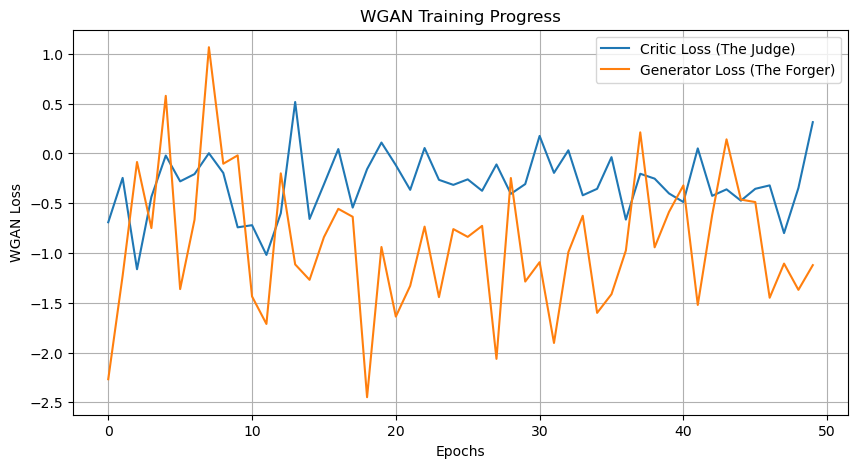

In [15]:
import torch.optim as optim
import matplotlib.pyplot as plt

# --- Hyperparameters ---
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
EPOCHS = 50        # Enough to see it learning
LAMBDA_GP = 10     # Standard penalty weight for WGAN-GP

# --- Optimizers ---
# We use Adam, which is standard for WGANs
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

print(f"Starting Training for {EPOCHS} Epochs...")
loss_history_g = []
loss_history_c = []

for epoch in range(EPOCHS):
    for batch_idx, (real,) in enumerate(dataloader):
        
        # Move real data to GPU
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # ---------------------
        #  1. Train Critic
        # ---------------------
        # The Critic gets to practice 5 times for every 1 turn the Generator gets
        for _ in range(5): 
            noise = torch.randn(cur_batch_size, Z_DIM).to(device)
            fake = gen(noise) # Generate fake traffic
            
            # Get scores from Critic
            critic_real = critic(real)
            critic_fake = critic(fake)
            
            # Calculate Penalty (The function we defined in Step 2)
            gp = compute_gradient_penalty(critic, real, fake)
            
            # WGAN Loss: maximize (Real Score - Fake Score)
            # We minimize the negative of that
            loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp)
            
            opt_critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # ---------------------
        #  2. Train Generator
        # ---------------------
        noise = torch.randn(cur_batch_size, Z_DIM).to(device)
        fake = gen(noise)
        gen_fake = critic(fake)
        
        # Generator wants to Maximize the Critic's score for its fakes
        # Create a penalty for non-zero values (L1 Norm)
        sparsity_penalty = torch.mean(torch.abs(fake)) 
        
        # Add it to the loss (0.1 is the weight/strength)
        loss_gen = -torch.mean(gen_fake) + (0.1 * sparsity_penalty)
        
        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
    # --- Logging ---
    loss_history_g.append(loss_gen.item())
    loss_history_c.append(loss_critic.item())
    
    if epoch % 5 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch [{epoch}/{EPOCHS}]  Loss D: {loss_critic.item():.4f}, Loss G: {loss_gen.item():.4f}")

print("Training Complete!")

# --- Visualize Training ---
plt.figure(figsize=(10,5))
plt.plot(loss_history_c, label='Critic Loss (The Judge)')
plt.plot(loss_history_g, label='Generator Loss (The Forger)')
plt.legend()
plt.title("WGAN Training Progress")
plt.xlabel("Epochs")
plt.ylabel("WGAN Loss")
plt.grid(True)
plt.show()

Metric     | Real Data       | Fake Data      
--------------------------------------------------
Mean       | -0.5023         | -0.5287        
Std        | 0.3000          | 0.2976         
Max        | 0.1905          | 0.2306         

Time Context Check:
Real Time Val: -0.48 (Normalized)
Fake Time Val: 0.63 (Normalized)


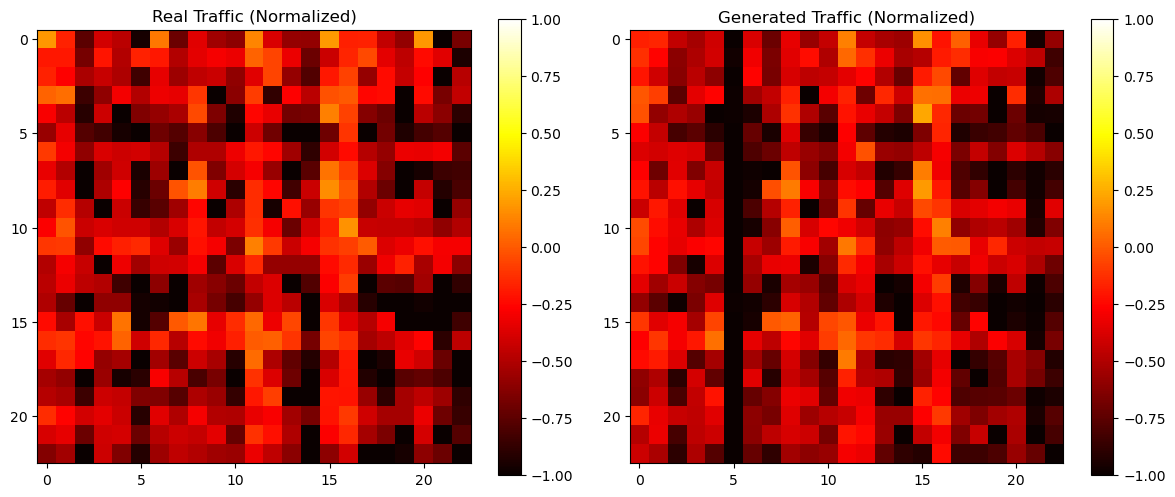

In [20]:

# --- Visualization & Statistics Code ---
gen.eval() 

# 1. Get a Real Sample
# We grab a batch and slice it
real_batch = next(iter(dataloader))[0] # Shape [64, 530]
real_time = real_batch[0, 0].item()    # First number is Time
real_traffic = real_batch[0, 1:]       # Rest is Traffic (529)
real_matrix = real_traffic.reshape(23, 23).numpy()

# 2. Generate a Fake Sample
with torch.no_grad():
    noise = torch.randn(1, Z_DIM).to(device)
    fake_output = gen(noise).cpu().numpy() # Shape [1, 530]
    
    fake_time = fake_output[0, 0]
    fake_traffic = fake_output[0, 1:]
    fake_matrix = fake_traffic.reshape(23, 23)

# 3. Calculate Statistics (On Traffic Only)
stats = {
    "Real": {
        "Mean": np.mean(real_matrix),
        "Std": np.std(real_matrix),
        "Max": np.max(real_matrix)
    },
    "Fake": {
        "Mean": np.mean(fake_matrix),
        "Std": np.std(fake_matrix),
        "Max": np.max(fake_matrix)
    }
}

# 4. Print Report
print(f"{'Metric':<10} | {'Real Data':<15} | {'Fake Data':<15}")
print("-" * 50)
for metric in ["Mean", "Std", "Max"]:
    print(f"{metric:<10} | {stats['Real'][metric]:<15.4f} | {stats['Fake'][metric]:<15.4f}")

print(f"\nTime Context Check:")
print(f"Real Time Val: {real_time:.2f} (Normalized)")
print(f"Fake Time Val: {fake_time:.2f} (Normalized)")

# 5. Plot Side-by-Side
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title(f"Real Traffic (Normalized)")
plt.imshow(real_matrix, cmap='hot', interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title(f"Generated Traffic (Normalized)")
plt.imshow(fake_matrix, cmap='hot', interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar()
plt.tight_layout()
plt.show()

In [21]:
# 1. Save the Trained Model (The Brain)
torch.save(gen.state_dict(), "gan_generator.pth")
print("Saved 'gan_generator.pth' (The Model Weights)")

# 2. Generate the Synthetic Data
print("Generating synthetic dataset for Mininet...")
num_samples = 2000 
gen.eval()

with torch.no_grad():
    noise = torch.randn(num_samples, Z_DIM).to(device)
    # Get the raw output from the generator (Values are between -1 and 1)
    fake_output = gen(noise).cpu().numpy() # Shape: (2000, 530)

# --- CRITICAL FIX: Separate Time from Traffic ---
# Column 0 is Time. Columns 1 to 529 are Traffic.
fake_time_norm = fake_output[:, 0]    # Shape (2000,)
fake_traffic_norm = fake_output[:, 1:] # Shape (2000, 529)

# 3. Inverse Normalization (Back to Log Scale)
# We use the t_min and t_max variables we calculated in Cell 1
# Formula: x = ((y + 1) / 2) * (max - min) + min
fake_log_scale = ((fake_traffic_norm + 1) / 2) * (t_max - t_min) + t_min

# 4. Inverse Log (Back to Real Raw Values)
# Formula: exp(x) - 1
fake_traffic_raw = np.expm1(fake_log_scale)

# 5. Convert to Mbps (Approximation for Mininet)
# The GÉANT data is likely in Bytes/15min. 
# We need to scale it down so Mininet doesn't freeze.
# This division factor (1,000,000) keeps numbers in the 0-100 range.
fake_traffic_mbps = fake_traffic_raw / 1000000 

# Clip negatives (caused by math precision) and cap massive spikes at 100 Mbps
fake_traffic_mbps = np.clip(fake_traffic_mbps, 0, 100) 

# 6. Save to CSV
# We only save the TRAFFIC (529 cols) for Mininet, ignoring the Time column
df_final = pd.DataFrame(fake_traffic_mbps)
df_final.to_csv("synthetic_traffic.csv", index=False, header=False)

print(f"Saved 'synthetic_traffic.csv'")
print(f"File Shape: {df_final.shape} (Should be 2000 rows, 529 cols)")
print("Mininet is ready to read this file!")

Saved 'gan_generator.pth' (The Model Weights)
Generating synthetic dataset for Mininet...
Saved 'synthetic_traffic.csv'
File Shape: (2000, 529) (Should be 2000 rows, 529 cols)
Mininet is ready to read this file!


C:\Users\santh\AppData\Local\Temp\ipykernel_4920\3382811863.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_gen.load_state_dict(torch.load("gan_generator.pth"))


✅ Model loaded successfully from 'gan_generator.pth'
Generating validation sample...
----------------------------------------
VERIFICATION REPORT
----------------------------------------
Total Output Shape: (1, 530) (Should be 1, 530)
Traffic Shape:      (529,) (Should be 529)
Generated Time:     -0.3674 (Normalized)
Traffic Range:      [-1.0000, 0.2266]


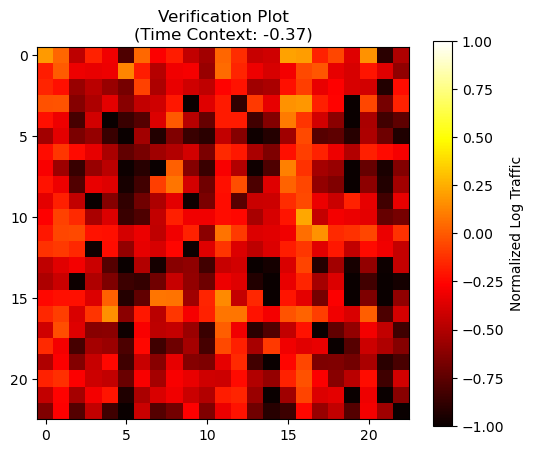

In [22]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Re-Define the Architecture (Must match EXACTLY) ---
Z_DIM = 100
DATA_DIM = 530  # <--- CRITICAL FIX: Changed from 529 to 530
HIDDEN_DIM = 128

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(Z_DIM, HIDDEN_DIM),
            nn.LayerNorm(HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM * 2),
            nn.LayerNorm(HIDDEN_DIM * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(HIDDEN_DIM * 2, HIDDEN_DIM * 4),
            nn.LayerNorm(HIDDEN_DIM * 4),
            nn.LeakyReLU(0.2),
            nn.Linear(HIDDEN_DIM * 4, DATA_DIM),
            nn.Tanh() 
        )

    def forward(self, x):
        return self.net(x)

# --- 2. Load the Saved Brain ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_gen = Generator().to(device)

try:
    # Changed path to local file (no /kaggle/input...)
    loaded_gen.load_state_dict(torch.load("gan_generator.pth"))
    loaded_gen.eval() # Set to "Test Mode"
    print("✅ Model loaded successfully from 'gan_generator.pth'")
except FileNotFoundError:
    print("❌ Error: File not found. Make sure you ran Cell 5 first!")

# --- 3. Generate Test Traffic ---
if 'loaded_gen' in locals():
    print("Generating validation sample...")
    with torch.no_grad():
        test_noise = torch.randn(1, Z_DIM).to(device)
        generated_data = loaded_gen(test_noise).cpu().numpy() # Shape is (1, 530)

    # --- 4. Separate Time and Traffic (The Fix) ---
    fake_time_val = generated_data[0, 0]      # The first number is Time
    fake_traffic_val = generated_data[0, 1:]  # The other 529 are Traffic

    # --- 5. Verify Output Statistics ---
    min_val = np.min(fake_traffic_val)
    max_val = np.max(fake_traffic_val)
    mean_val = np.mean(fake_traffic_val)

    print("-" * 40)
    print(f"VERIFICATION REPORT")
    print("-" * 40)
    print(f"Total Output Shape: {generated_data.shape} (Should be 1, 530)")
    print(f"Traffic Shape:      {fake_traffic_val.shape} (Should be 529)")
    print(f"Generated Time:     {fake_time_val:.4f} (Normalized)")
    print(f"Traffic Range:      [{min_val:.4f}, {max_val:.4f}]")

    # --- 6. Visual Check ---
    # Now we reshape ONLY the traffic part
    matrix = fake_traffic_val.reshape(23, 23)
    
    plt.figure(figsize=(6, 5))
    plt.title(f"Verification Plot\n(Time Context: {fake_time_val:.2f})")
    plt.imshow(matrix, cmap='hot', interpolation='nearest', vmin=-1, vmax=1)
    plt.colorbar(label='Normalized Log Traffic')
    plt.show()

In [24]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Save the Trained Model (The Brain)
torch.save(gen.state_dict(), "gan_generator.pth")
print("Saved 'gan_generator.pth' (The Model Weights)")

# 2. Generate the Synthetic Data
print("Generating synthetic dataset for Mininet...")
num_samples = 2000 
gen.eval()

with torch.no_grad():
    noise = torch.randn(num_samples, Z_DIM).to(device)
    # Get the raw output [2000 rows, 530 cols]
    fake_output = gen(noise).cpu().numpy() 

# --- STEP A: Separate Time and Traffic ---
# Drop the Time Column (Col 0)
fake_traffic_norm = fake_output[:, 1:] # Shape: (2000, 529)

# --- STEP B: The "Cookie Cutter" (Slice 23x23 -> 16x16) ---
# We need to reshape to matrix to slice correctly
# 1. Reshape to (Samples, 23, 23)
traffic_matrix_23 = fake_traffic_norm.reshape(num_samples, 23, 23)

# 2. Slice the top-left 16x16 (Matches your Fat-Tree Hosts)
traffic_matrix_16 = traffic_matrix_23[:, :16, :16]

# 3. Flatten back to rows (Samples, 256)
fake_traffic_16_flat = traffic_matrix_16.reshape(num_samples, -1)

print(f"Resized Traffic from {fake_traffic_norm.shape} to {fake_traffic_16_flat.shape}")

# --- STEP C: Inverse Normalization (On the 16x16 data) ---
# Formula: x = ((y + 1) / 2) * (max - min) + min
# Note: We use the same t_max/t_min because the scale of traffic is the same
fake_log_scale = ((fake_traffic_16_flat + 1) / 2) * (t_max - t_min) + t_min

# --- STEP D: Inverse Log & Mbps Conversion ---
fake_traffic_raw = np.expm1(fake_log_scale)

# Convert to Mbps and Clip
fake_traffic_mbps = fake_traffic_raw / 1000000 
fake_traffic_mbps = np.clip(fake_traffic_mbps, 0, 100) 

# --- STEP E: Save to CSV ---
df_final = pd.DataFrame(fake_traffic_mbps)
df_final.to_csv("synthetic_traffic_16hosts.csv", index=False, header=False)

print(f"Saved 'synthetic_traffic_16hosts.csv'")
print(f"Final Format: {df_final.shape} (2000 Rows, 256 Columns)")
print("✅ This file is now perfectly formatted for a 16-Host Mininet!")


Saved 'gan_generator.pth' (The Model Weights)
Generating synthetic dataset for Mininet...
Resized Traffic from (2000, 529) to (2000, 256)
Saved 'synthetic_traffic_16hosts.csv'
Final Format: (2000, 256) (2000 Rows, 256 Columns)
✅ This file is now perfectly formatted for a 16-Host Mininet!
